In [13]:
segmentation("/Users/rei/Downloads/arashi.jpeg", "result.jpeg")

NameError: name 'ptint' is not defined

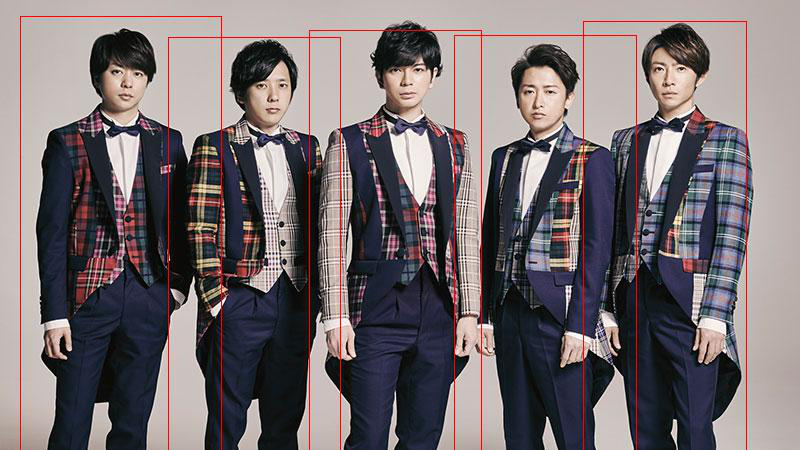

In [17]:
I.open("result.jpeg")

In [14]:
import cv2
from numpy import *
import PIL.Image as I
from chainercv.links.model import faster_rcnn

#rgb = array(I.open("rei.png").resize((int(800), int(r * 800))).convert("RGB"))
#rgb = array(I.open("/Users/yu/Downloads/tmp.jpg").resize((int(800), int(r * 800))).convert("RGB"))

def segmentation(input_image_path, output_image_path):

    model = faster_rcnn.FasterRCNNVGG16(pretrained_model='voc07')
    im_raw = I.open(input_image_path)
    w, h = im_raw.size
    r = h / w
    rgb = array(im_raw.resize((int(800), int(r * 800))).convert("RGB"))

    img = asarray(rgb, dtype = float32).transpose((2, 0, 1))
    bbox, c, acc = model.predict([img])
    for b in bbox[0]:
        y_min, x_min, y_max, x_max = b
        rgb  = cv2.rectangle(rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0))
    I.fromarray(rgb).resize(im_raw.size).save(output_image_path)
    print("Prosess has been done successfully")

In [ ]:
# pythonのスクリプトにして実行した時にオプションをつけるためのモジュール
import argparse
# 描画用
import matplotlib.pyplot as plt

import cv2
import numpy as np
from timeit import default_timer as timer
 
# from chainercv.datasets import voc_bbox_label_names, voc_semantic_segmentation_label_colors
from chainercv.datasets import sbd_instance_segmentation_label_names
from chainercv.experimental.links import FCISResNet101
from chainercv.utils import mask_to_bbox
from chainercv.visualizations.colormap import voc_colormap
from chainercv.visualizations import vis_instance_segmentation
 
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--gpu', type=int, default=-1)
    parser.add_argument('--pretrained-model', default='sbd')
    parser.add_argument('video')
    args = parser.parse_args()
 
    model = FCISResNet101(
        n_fg_class=20, pretrained_model=args.pretrained_model)
 
    if args.gpu >= 0:
        chainer.cuda.get_device_from_id(args.gpu).use()
        model.to_gpu()
 
    if args.video == "0":
        vid = cv2.VideoCapture(0)
    else:
        vid = cv2.VideoCapture(args.video)
    if not vid.isOpened():
        raise ImportError("Couldn't open video file or webcam.")
 
    # Compute aspect ratio of video
    vidw = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
    vidh = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
    # vidar = vidw / vidh
    print(vidw)
    print(vidh)
 
    accum_time = 0
    curr_fps = 0
    fps = "FPS: ??"
    prev_time = timer()
 
    frame_count = 1
    while True:
        ret, frame = vid.read()
        if ret == False:
            print("Done!")
            return
 
        # BGR -> RGB
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
 
        # Result image
        result = frame.copy()
 
        # (H, W, C) -> (C, H, W)
        img = np.asarray(rgb, dtype = np.float32).transpose((2, 0, 1))
 
        # Object Detection
        masks, labels, scores = model.predict([img])
        mask, label, score = masks[0], labels[0], scores[0]
        bbox = mask_to_bbox(mask)
        colors = voc_colormap(list(range(1, len(mask) + 1)))
 
        # For Colors
        n_inst = len(bbox)
        instance_colors = voc_colormap(list(range(1, n_inst + 1)))
        instance_colors = np.array(instance_colors)
 
        # For Mask
        _, H, W = mask.shape
        canvas_img = np.zeros((H, W, 4), dtype=np.uint8)
        alf_img = np.zeros((H, W, 1), dtype=np.uint8)
        
        if len(bbox) != 0:
            # for i, bb in enumerate(bbox):
            for i, (bb, msk) in enumerate(zip(bbox, mask)):
                # print(i)
                lb = label[i]
                conf = score[i].tolist()
                ymin = int(bb[0])
                xmin = int(bb[1])
                ymax = int(bb[2])
                xmax = int(bb[3])
 
                class_num = int(lb)
 
                # Draw box
                # cv2.rectangle(result, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
 
                text = sbd_instance_segmentation_label_names[class_num] + " " + ('%.2f' % conf)
                print(text)
 
                # text_pos 1
                test_x = round(xmax-xmin/2)-30
                test_y = round(ymax-ymin/2)-30
                text_top = (test_x, test_y-10)
                text_bot = (test_x + 80, test_y + 5)
                text_pos = (test_x + 5, test_y)
 
                # text_pos 2
                # text_top = (xmin, ymin - 10)
                # text_bot = (xmin + 80, ymin + 5)
                # text_pos = (xmin + 5, ymin)
 
                # Draw label
                cv2.rectangle(result, text_top, text_bot, (255,255,255), -1)
                cv2.putText(result, text, text_pos, 
                cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 0), 1)
 
                # Draw msk 1
                color = instance_colors[i % len(instance_colors)]
                rgba = np.append(color, 0.7 * 255) # alpha=0.7
                if ymax > ymin and xmax > xmin:
                    canvas_img[msk] = rgba
                    mask_img = np.asarray(canvas_img)
                    tmp_bgr = cv2.split(result)
                    mask_result = cv2.merge(tmp_bgr + [alf_img])
                    mask_result = cv2.addWeighted(mask_result, 1, mask_img, 0.5, 0)
 
                # Draw msk 2
                # rgba = np.append((0,255,0), 0.7 * 255) # alpha=0.7
                # if ymax > ymin and xmax > xmin:
                #     canvas_img[msk] = rgba
                #     mask_img = np.asarray(canvas_img)
                #     tmp_bgr = cv2.split(result)
                #     mask_result = cv2.merge(tmp_bgr + [alf_img])
                #     mask_result = cv2.addWeighted(mask_result, 1, mask_img, 0.5, 0)
 
        # Calculate FPS
        curr_time = timer()
        exec_time = curr_time - prev_time
        prev_time = curr_time
        accum_time = accum_time + exec_time
        curr_fps = curr_fps + 1
        if accum_time > 1:
            accum_time = accum_time - 1
            fps = "FPS:" + str(curr_fps)
            curr_fps = 0
 
        # Draw FPS in top right corner
        cv2.rectangle(result, (590, 0), (640, 17), (0, 0, 0), -1)
        cv2.putText(result, fps, (595, 10), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255), 1)
 
        # Draw Frame Number
        cv2.rectangle(result, (0, 0), (50, 17), (0, 0, 0), -1)
        cv2.putText(result, str(frame_count), (0, 10), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255), 1)
 
        # Output Result
        cv2.imshow("BBOX Result", result)
        cv2.imshow("Mask img", mask_img)
        cv2.imshow("Fcis Result", mask_result)
 
        # For Debug
        print("===== BBOX Result =====")
        print(type(result))
        print(result.shape)
        print(type(result.shape))
        
        print("===== Mask img =====")
        print(type(mask_img))
        print(mask_img.shape)
        print(type(mask_img.shape))
        
        # Stop Processing
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
 
        frame_count += 1
 
if __name__ == '__main__':
    main()d